In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from joblib import load
from sklearn.preprocessing import StandardScaler

### Config

In [2]:
target_gauge_id = 3900
predict_next_hours = 12

### Data Loading

In [3]:
data = pd.read_csv(f"../dataset/processed/simple/{target_gauge_id}/{predict_next_hours}.gz")
data.dropna(how="any", inplace=True)

In [4]:
index = data.index
x_data = data.loc[:, (data.columns != "DATE") & (data.columns != "TARGET")]
y_data = data["TARGET"]

In [5]:
len(index)

2761

### Data Processing

In [6]:
# Normalize datasets with scaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data.values)

In [7]:
# Convert to PyTorch tensors
x_tensor = torch.tensor(x_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_data.values, dtype=torch.float32).view(-1, 1)

### Model Setup

In [8]:
# Instantiate the model
model = nn.Sequential(
    nn.Linear(x_tensor.shape[1], x_tensor.shape[1] * 2),
    nn.ReLU(),
    nn.Linear(x_tensor.shape[1] * 2, x_tensor.shape[1]),
    nn.ReLU(),
    nn.Linear(x_tensor.shape[1], x_tensor.shape[1] // 4),
    nn.ReLU(),
    nn.Linear(x_tensor.shape[1] // 4, 1),
    nn.Softplus(),
)

### Model Loading

In [9]:
directory = f"../models/simple/{target_gauge_id}"

# Load our scaler
scaler = load(f"{directory}/{predict_next_hours}.bin")

# Load our model
model.load_state_dict(torch.load(f"{directory}/{predict_next_hours}.pth", map_location=torch.device("cpu")))
model.eval()

Sequential(
  (0): Linear(in_features=5037, out_features=10074, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10074, out_features=5037, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5037, out_features=1259, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1259, out_features=1, bias=True)
  (7): Softplus(beta=1.0, threshold=20.0)
)

### Model Evaluation

In [10]:
with torch.no_grad():
    y_pred = pd.DataFrame(model(x_tensor).numpy(), columns=["PREDICTION"])
    results = pd.merge(y_data.reset_index(drop=True), y_pred, left_index=True, right_index=True)

In [11]:
results

,TARGET,PREDICTION
0,170.5,169.630219
1,156.5,159.726654
2,145.0,148.466934
3,138.5,138.350372
4,126.5,126.739113
...,...,...
2756,181.0,177.514771
2757,175.0,164.719452
2758,150.5,148.744568
2759,133.0,130.731598


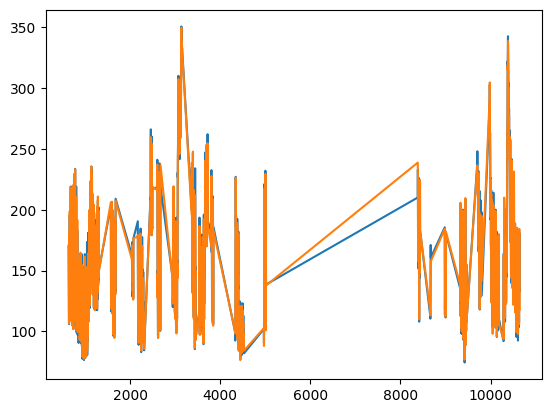

In [12]:
plt.plot(index, results)
plt.show()